In [1]:
%cd ..

/home/denis/code/ML_model_implementation


/home/denis/.local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# Лабораторная работа №1 (Проведение исследований с алгоритмом KNN)

In [2]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, balanced_accuracy_score, precision_score, recall_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from phik import phik_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from phik.report import plot_correlation_matrix
pd.set_option('display.max_columns', None)

## Часть 1: Выбор начальных условий

### Набор данных для классификации

In [3]:
data = pd.read_csv("./data/gym_members_exercise_tracking.csv")

In [4]:
data.head()

Age  Gender  Weight (kg)  Height (m)  Max_BPM  Avg_BPM  Resting_BPM  \
0   56    Male         88.3        1.71      180      157           60   
1   46  Female         74.9        1.53      179      151           66   
2   32  Female         68.1        1.66      167      122           54   
3   25    Male         53.2        1.70      190      164           56   
4   38    Male         46.1        1.79      188      158           68   

   Session_Duration (hours)  Calories_Burned Workout_Type  Fat_Percentage  \
0                      1.69           1313.0         Yoga            12.6   
1                      1.30            883.0         HIIT            33.9   
2                      1.11            677.0       Cardio            33.4   
3                      0.59            532.0     Strength            28.8   
4                      0.64            556.0     Strength            29.2   

   Water_Intake (liters)  Workout_Frequency (days/week)  Experience_Level  \
0                    3.5                              4                 3   
1                    2.1                              4                 2   
2                    2.3                              4                 2   
3                    2.1                              3                 1   
4                    2.8                              3                 1   

     BMI  
0  30.20  
1  32.00  
2  24.71  
3  18.41  
4  14.39

### Описание фичей:

- Age: возраст посетителя тренажерного зала.
- Gender: пол посетителя тренажерного зала (мужчина или женщина).
- Weight (kg): вес участника в килограммах.
- Height (m): рост участника в метрах.
- Max_BPM: максимальная частота сердечных сокращений (ударов в минуту) во время тренировок.
- Avg_BPM: средняя частота сердечных сокращений во время тренировок.
- Resting_BPM: частота сердечных сокращений в состоянии покоя перед тренировкой.
- Session_Duration (hours): продолжительность каждой тренировки в часах.
- Calories_Burned: общее количество сожженных калорий за каждую тренировку.
- Workout_Type: Тип выполняемой тренировки (например, кардио, силовая, йога, HIIT).
- Fat_Percentage: процентное содержание жира в организме участника.
- Water_Intake (liters): ежедневное потребление воды во время тренировок.
- Workout_Frequency (days/week): количество тренировок в неделю.
- Experience_Level: уровень опыта, от новичка (1) до эксперта (3).
- BMI: индекс массы тела, рассчитываемый исходя из роста и веса.

#### Разобьем на категориальные и числовые колонки

In [5]:
# Категориальные колонки
categorical_columns = [
    'Workout_Type', 'Experience_Level'
]

# Колонка-таргет
target_columns = 'Gender'

# Числовые колонки
numerical_columns = data.columns[~data.columns.isin(categorical_columns + [target_columns])].tolist()

Превратим object в числовые значения и укажем явно, что это категориальный тип данных

In [6]:
label_encoder = {"Workout_Type": LabelEncoder(), "Gender": LabelEncoder()}
data["Workout_Type"] = label_encoder["Workout_Type"].fit_transform(data["Workout_Type"])
data["Gender"] = label_encoder["Gender"].fit_transform(data["Gender"])

In [7]:
data[categorical_columns + [target_columns]] = data[categorical_columns + [target_columns]].astype('category')

Разобьем выборку на трэин и валидацию

In [8]:
train, valid = train_test_split(data, train_size=0.8, random_state=42, shuffle=True, stratify=data[target_columns])

In [9]:
X_train = train.drop(columns=target_columns, inplace=False)
y_train = train[target_columns]

X_valid = valid.drop(columns=target_columns, inplace=False)
y_valid = valid[target_columns]

- В качестве датасета для классификации я взял показатели физической подготовки и физических характеристик
- Таргет - Gender: пол
- В качестве метрики качества буду использовать F1-score, тк хорошая метрика для классификации, учитывающая точность и полноту, Balanced Accuracy, тк она проще всего для понимания и учитывает дисбаланс классов, и в отдельности Precision и Recall

## Часть 2: Создание бейзлайна и оценка качества

### A: Обучение модели

Для начала сделаем препроцессор и закинем его вместе с pipeline в модель

In [10]:
model = KNeighborsClassifier()

Обучаем модель

In [11]:
model.fit(X_train, y_train)

KNeighborsClassifier()

Делаем предсказания по тренировочной выборке и валидационной

In [12]:
train_predict = model.predict(X_train)
valid_predict = model.predict(X_valid)

### B: Оценка качества модели

In [13]:
# Расчет метрик для тренировочных предсказаний
train_f1 = f1_score(y_train, train_predict)
train_balanced_accuracy = balanced_accuracy_score(y_train, train_predict)
train_precision = precision_score(y_train, train_predict, average='macro')
train_recall = recall_score(y_train, train_predict, average='macro')

# Расчет метрик для валидационных предсказаний
valid_f1 = f1_score(y_valid, valid_predict)
valid_balanced_accuracy = balanced_accuracy_score(y_valid, valid_predict)
valid_precision = precision_score(y_valid, valid_predict, average='macro')
valid_recall = recall_score(y_valid, valid_predict, average='macro')

# Сводка метрик в таблицу для удобного отображения
metrics_df = pd.DataFrame({
    'Метрика': ['F1', 'Balanced Accuracy', 'Precision', 'Recall'],
    'Тренировочная выборка': [train_f1, train_balanced_accuracy, train_precision, train_recall],
    'Валидационная выборка': [valid_f1, valid_balanced_accuracy, valid_precision, valid_recall]
})

In [14]:
metrics_df.head()

Метрика  Тренировочная выборка  Валидационная выборка
0                 F1               0.843061               0.764398
1  Balanced Accuracy               0.847175               0.771822
2          Precision               0.847933               0.773320
3             Recall               0.847175               0.771822

Визуализируем метрики

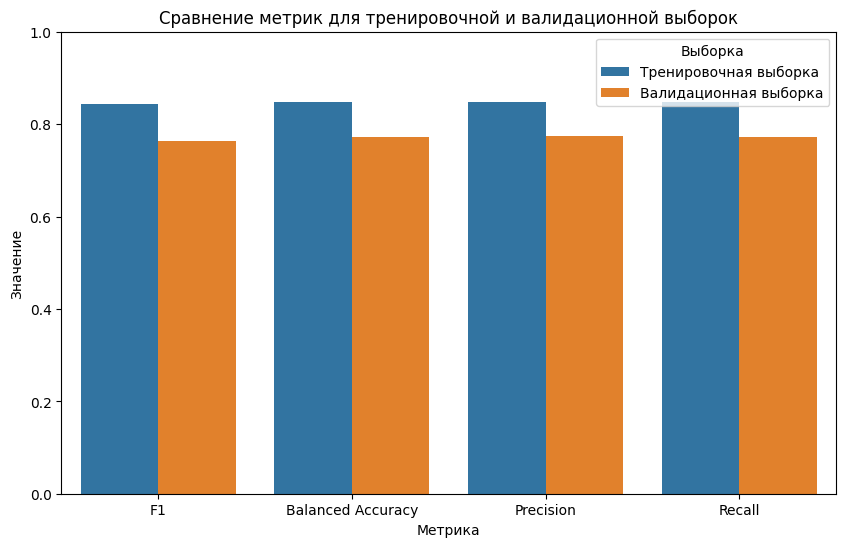

In [15]:
# Визуализация метрик
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df.melt(id_vars='Метрика', var_name='Выборка', value_name='Значение'),
            x='Метрика', y='Значение', hue='Выборка')
plt.title('Сравнение метрик для тренировочной и валидационной выборок')
plt.ylim(0, 1)
plt.legend(title='Выборка')
plt.show()

Как видим, качество модели очень плохое без предобработки, ее стоит дорабатывать

## Улучшение бейзлайна

### EDA

In [16]:
train.head()

Age Gender  Weight (kg)  Height (m)  Max_BPM  Avg_BPM  Resting_BPM  \
22    50      0         71.0        1.68      187      161           70   
749   28      0         79.6        1.59      181      130           54   
551   30      1        113.4        1.91      177      137           54   
183   19      1         87.8        1.78      195      161           72   
277   50      1         51.5        1.71      199      155           64   

     Session_Duration (hours)  Calories_Burned Workout_Type  Fat_Percentage  \
22                       1.17            848.0            3            33.1   
749                      1.49            968.0            1            28.2   
551                      1.27            957.0            1            22.2   
183                      1.28           1133.0            0            23.6   
277                      1.48           1136.0            3            20.9   

     Water_Intake (liters)  Workout_Frequency (days/week) Experience_Level  \
22                     2.5                              2                1   
749                    1.5                              3                2   
551                    3.7                              3                1   
183                    3.3                              2                1   
277                    2.9                              2                1   

       BMI  
22   25.16  
749  31.49  
551  31.08  
183  27.71  
277  17.61

In [17]:
y_train.value_counts()

1    409
0    369
Name: Gender, dtype: int64

#### Определим кол-во пустых значений в каждой фиче

In [18]:
data.isna().sum()

Age                              0
Gender                           0
Weight (kg)                      0
Height (m)                       0
Max_BPM                          0
Avg_BPM                          0
Resting_BPM                      0
Session_Duration (hours)         0
Calories_Burned                  0
Workout_Type                     0
Fat_Percentage                   0
Water_Intake (liters)            0
Workout_Frequency (days/week)    0
Experience_Level                 0
BMI                              0
dtype: int64

Пустых значений нет

### Проверим на выбросы Gender и посмотрим кол-во каждых значений

In [19]:
train.nunique()

Age                               42
Gender                             2
Weight (kg)                      476
Height (m)                        51
Max_BPM                           40
Avg_BPM                           50
Resting_BPM                       25
Session_Duration (hours)         146
Calories_Burned                  543
Workout_Type                       4
Fat_Percentage                   228
Water_Intake (liters)             23
Workout_Frequency (days/week)      4
Experience_Level                   3
BMI                              636
dtype: int64

В Gender нет выбросов

### Выведем основные характеристики фичей

In [20]:
numeric_stats = train.select_dtypes(include=['number']).describe()
categorical_stats = train.select_dtypes(include=['category', 'object']).describe()

In [21]:
numeric_stats

Age  Weight (kg)  Height (m)     Max_BPM     Avg_BPM  \
count  778.000000   778.000000  778.000000  778.000000  778.000000   
mean    38.359897    74.507455    1.727442  179.791774  144.367609   
std     12.209625    21.388131    0.124711   11.717847   14.408495   
min     18.000000    40.000000    1.500000  160.000000  120.000000   
25%     28.000000    58.825000    1.630000  170.000000  132.000000   
50%     39.000000    70.250000    1.720000  180.000000  144.000000   
75%     49.000000    86.475000    1.800000  190.000000  157.000000   
max     59.000000   129.900000    2.000000  199.000000  169.000000   

       Resting_BPM  Session_Duration (hours)  Calories_Burned  Fat_Percentage  \
count   778.000000                778.000000       778.000000      778.000000   
mean     62.340617                  1.243188       900.537275       25.121208   
std       7.280794                  0.341173       270.468271        6.212277   
min      50.000000                  0.500000       303.000000       10.000000   
25%      56.000000                  1.030000       719.000000       21.300000   
50%      62.500000                  1.250000       886.000000       26.400000   
75%      68.000000                  1.430000      1071.750000       29.400000   
max      74.000000                  2.000000      1783.000000       35.000000   

       Water_Intake (liters)  Workout_Frequency (days/week)         BMI  
count             778.000000                     778.000000  778.000000  
mean                2.621851                       3.303342   24.964614  
std                 0.595293                       0.902172    6.642893  
min                 1.500000                       2.000000   12.320000  
25%                 2.200000                       3.000000   20.217500  
50%                 2.600000                       3.000000   24.080000  
75%                 3.100000                       4.000000   28.455000  
max                 3.700000                       5.000000   49.840000

In [22]:
categorical_stats

Gender  Workout_Type  Experience_Level
count      778           778               778
unique       2             4                 3
top          1             2                 2
freq       409           206               325

#### Кол-во дубликатов

In [23]:
sum(train.duplicated())

0

Дубликатов нет

### Визуализируем данные

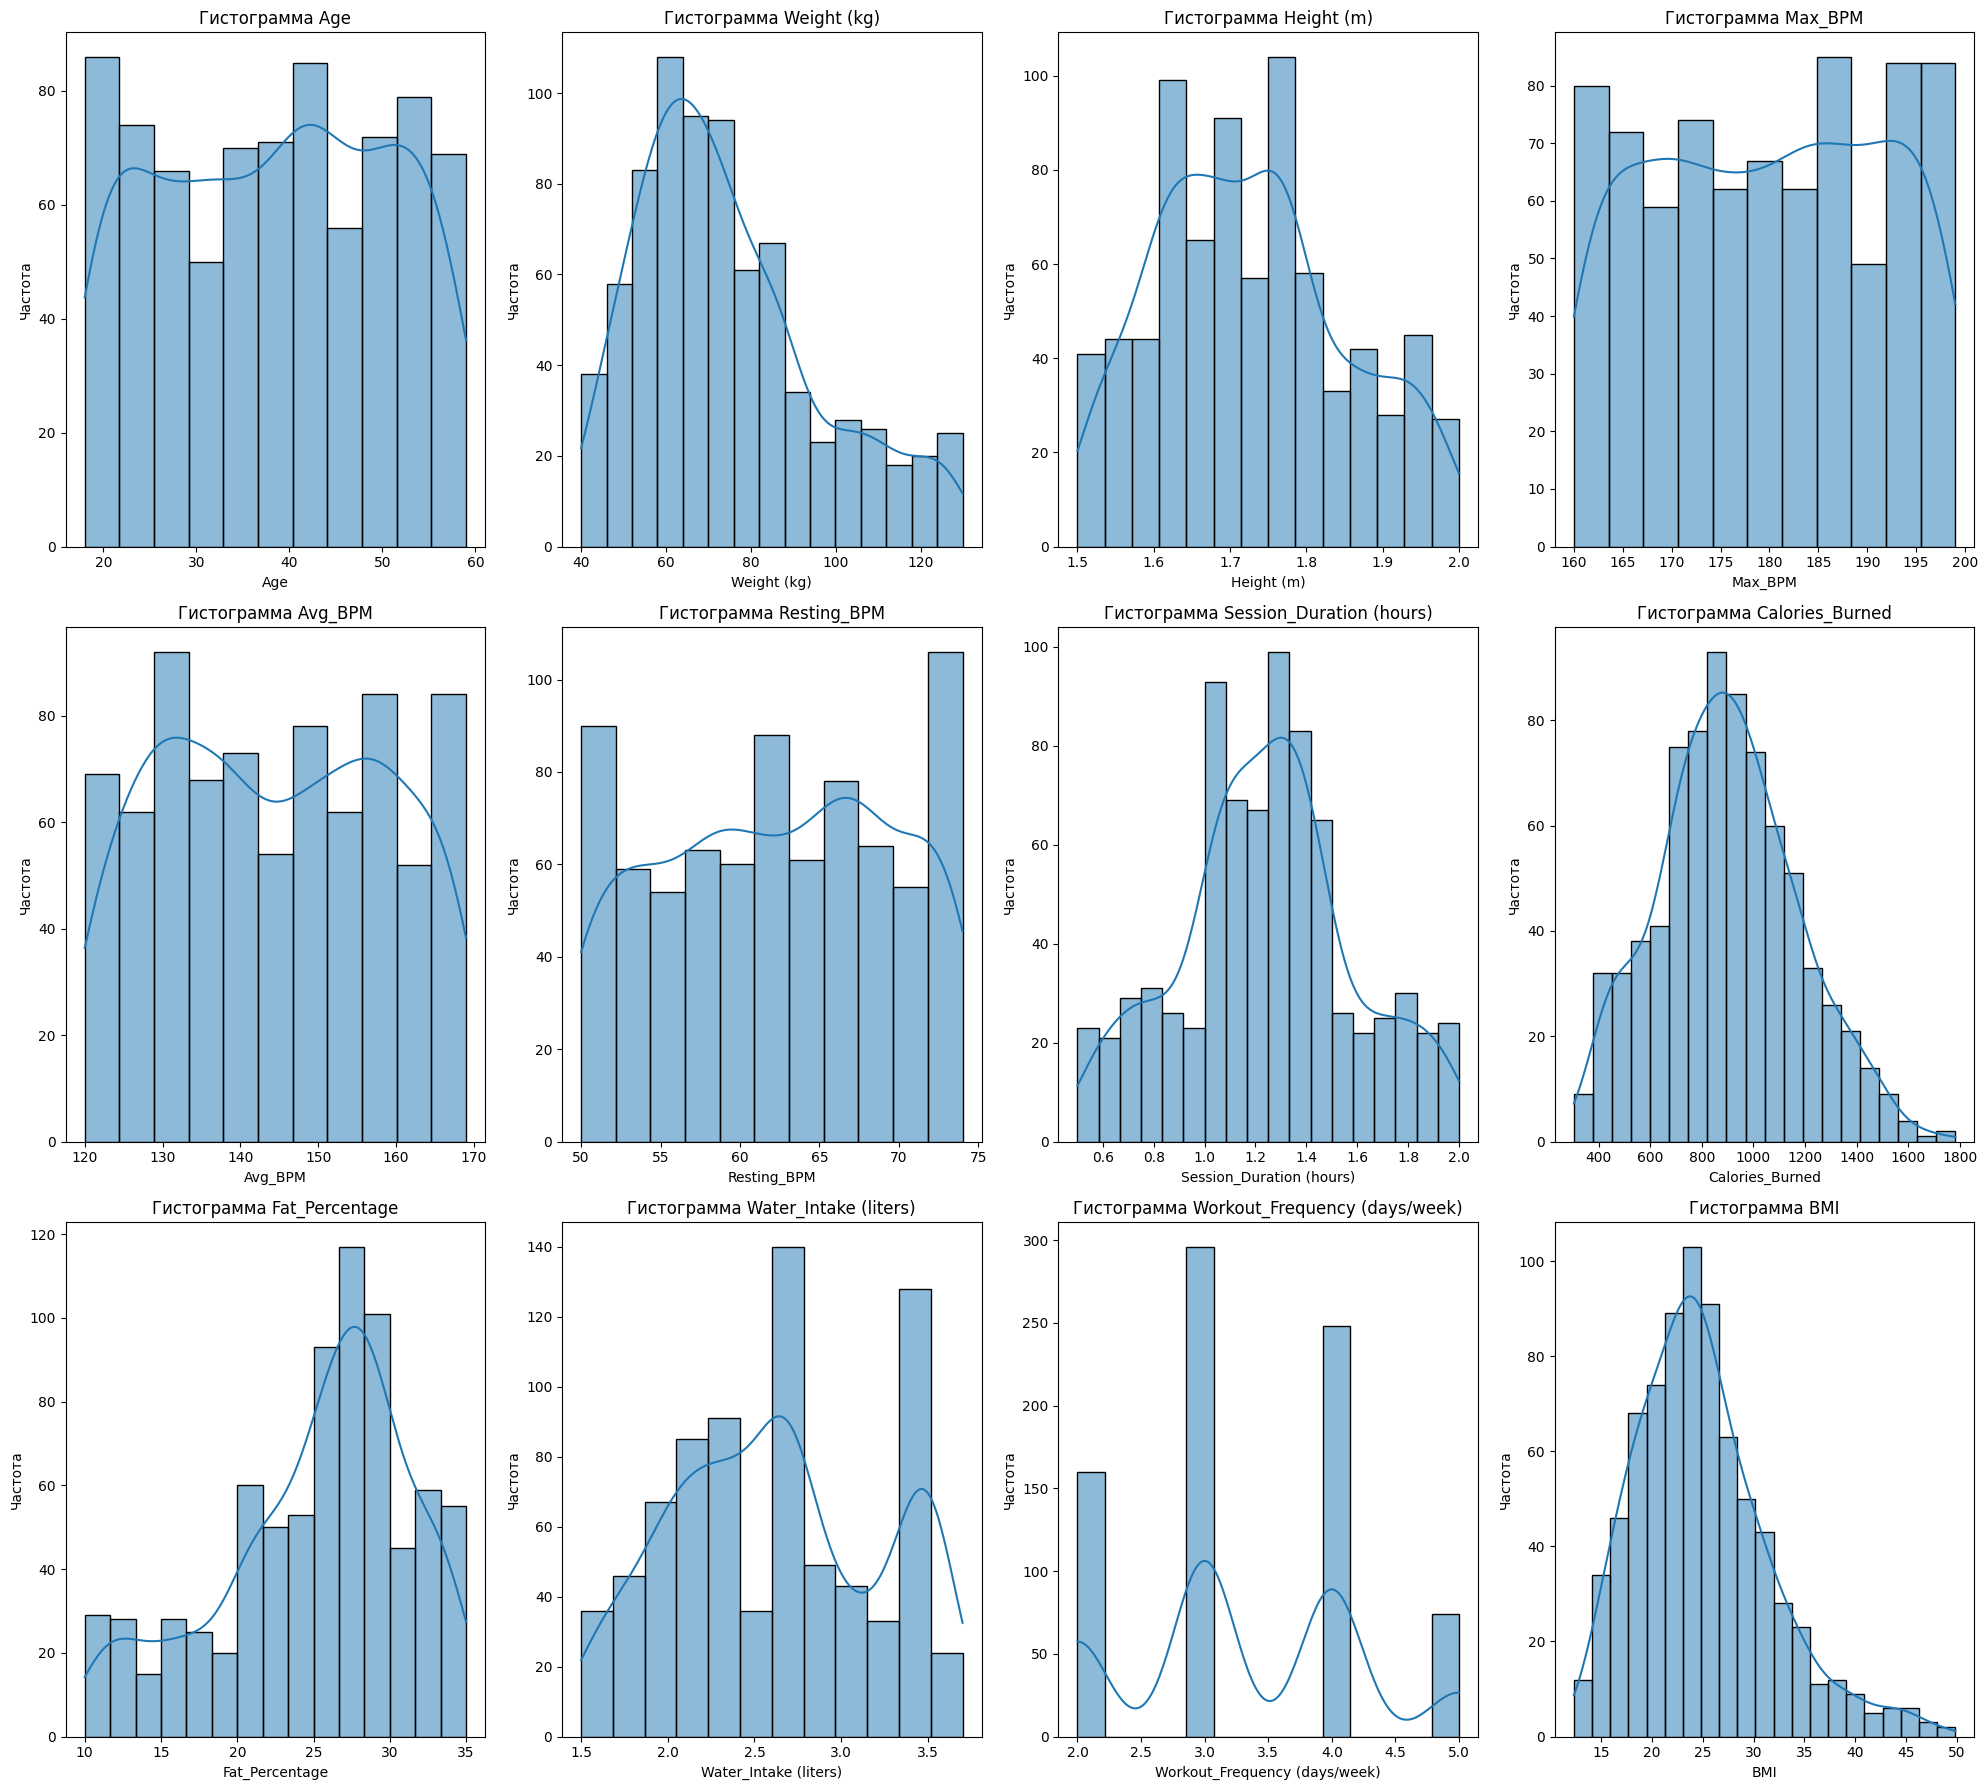

In [24]:
n_cols = 4
n_rows = (len(numerical_columns) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 6))
axes = axes.flatten()

for idx, col in enumerate(numerical_columns):
    sns.histplot(train[col], kde=True, ax=axes[idx])
    axes[idx].set_title(f'Гистограмма {col}')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Частота')

for i in range(len(numerical_columns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

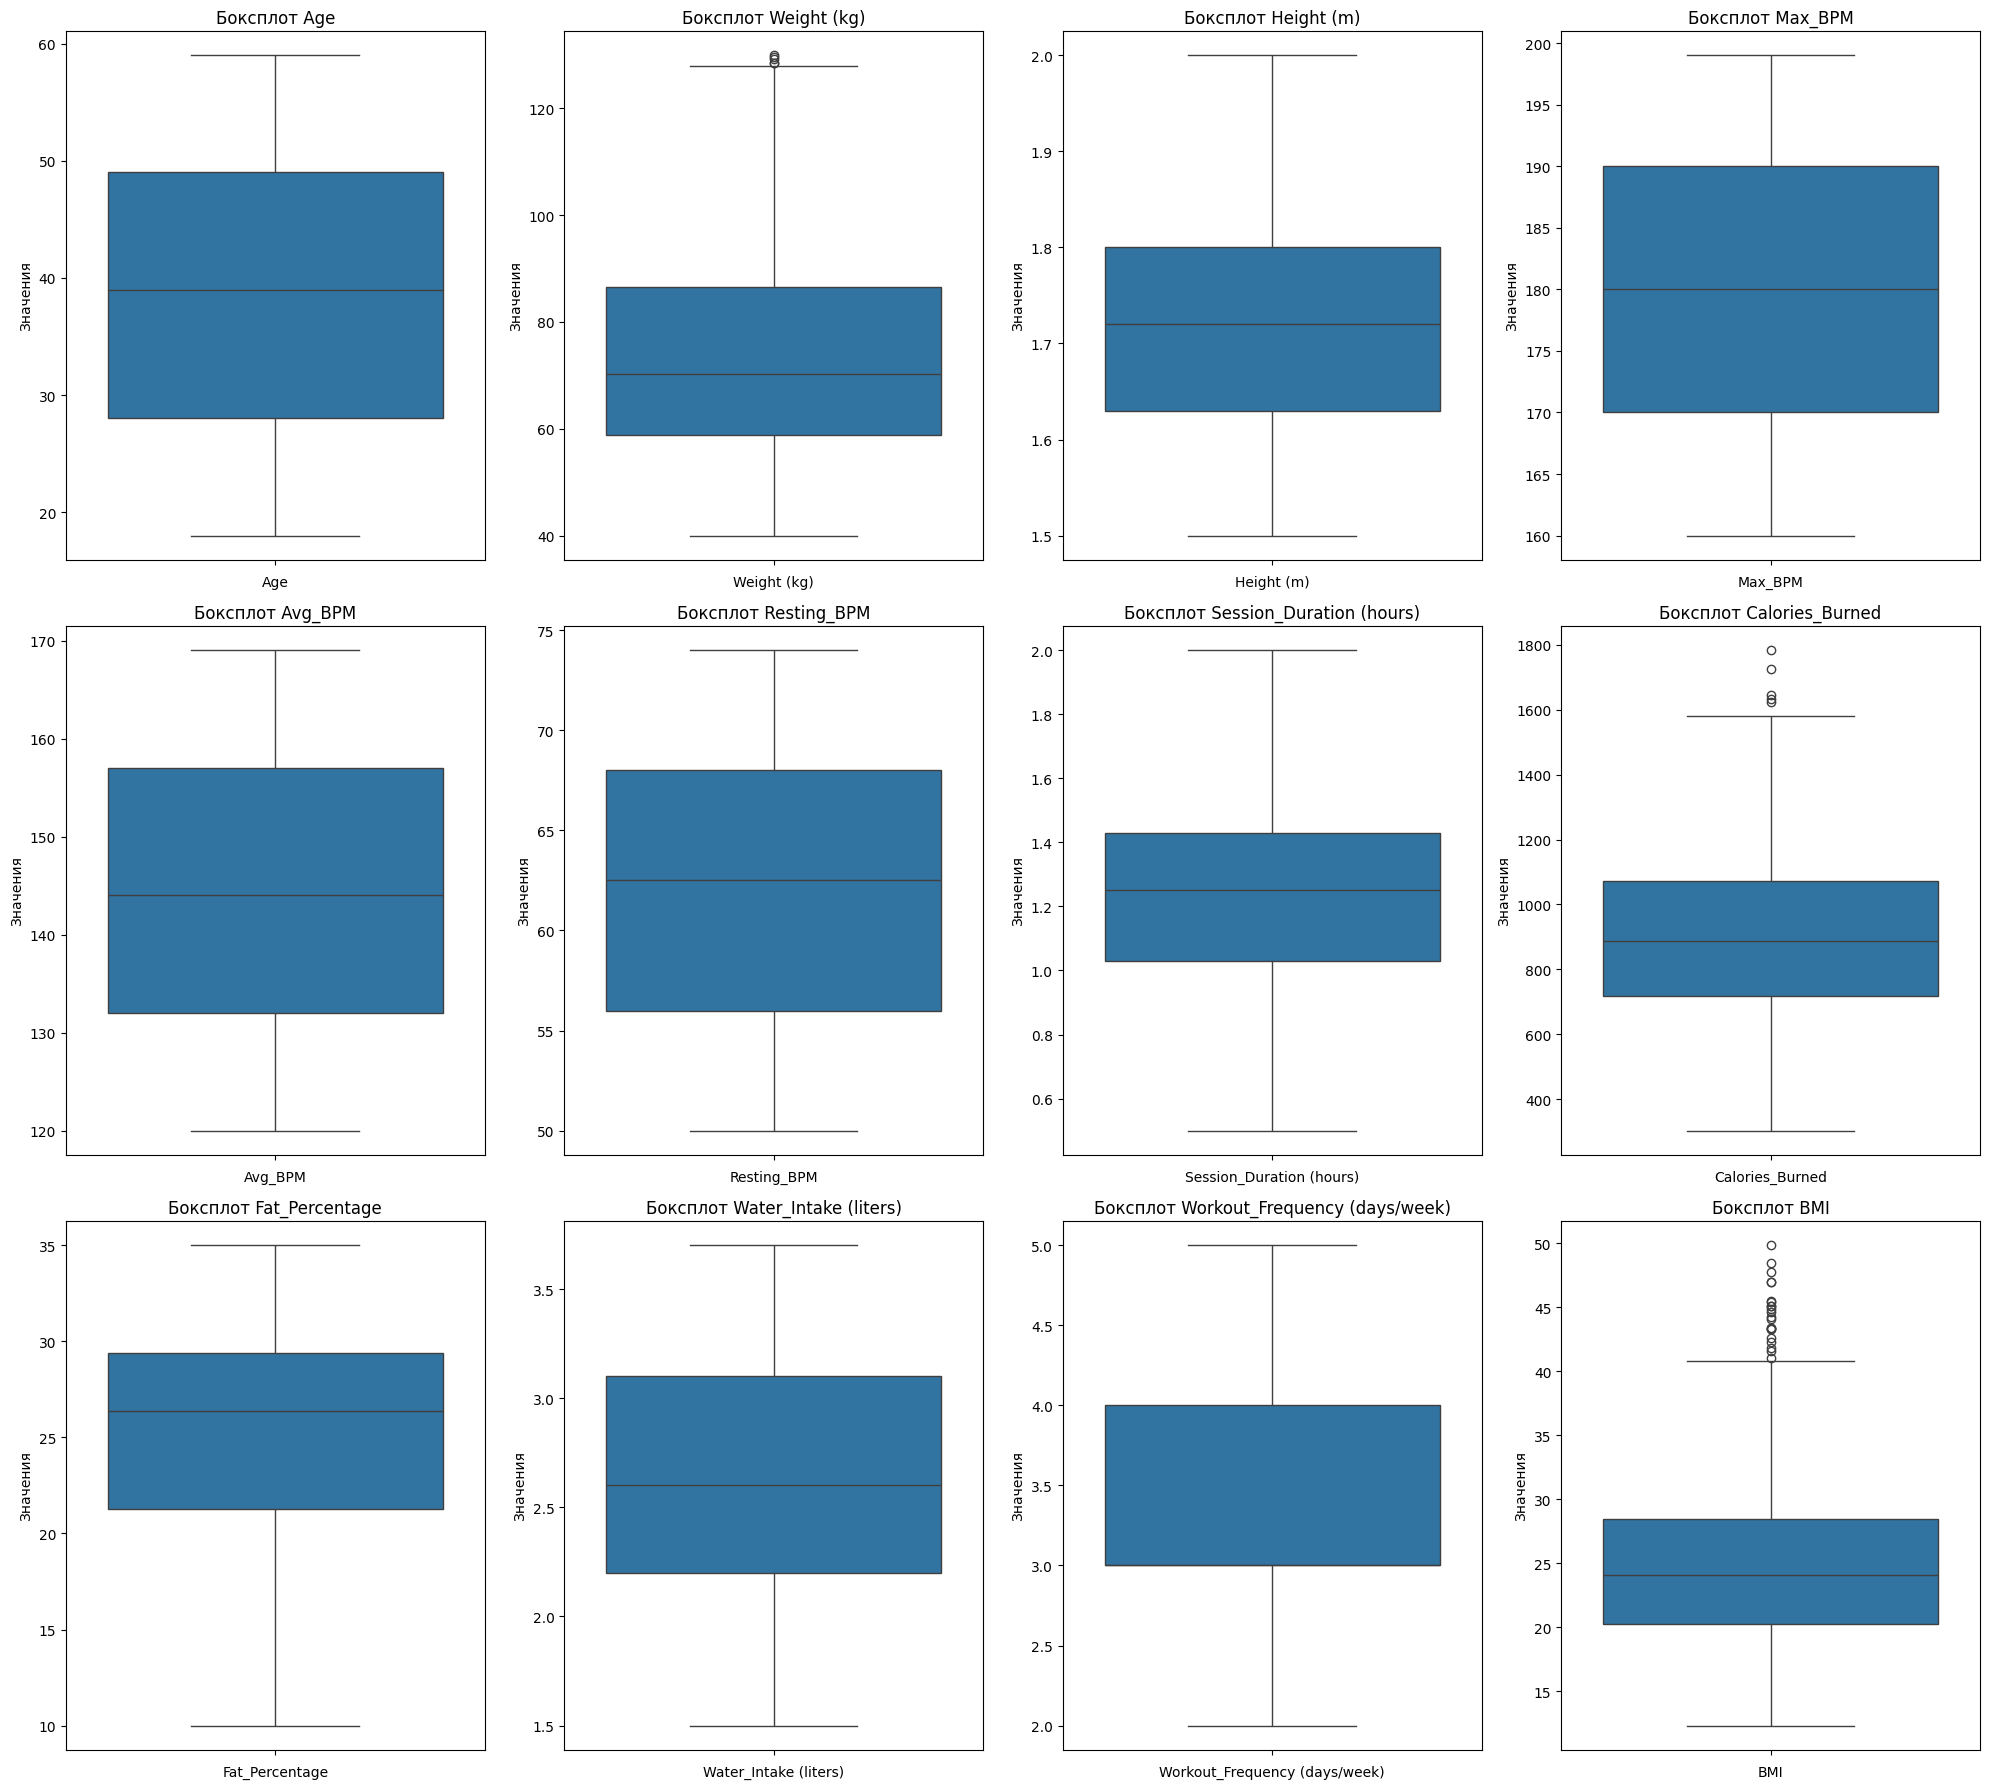

In [25]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 6))
axes = axes.flatten()

for idx, col in enumerate(numerical_columns):
    sns.boxplot(y=train[col], ax=axes[idx])
    axes[idx].set_title(f'Боксплот {col}')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Значения')

for i in range(len(numerical_columns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

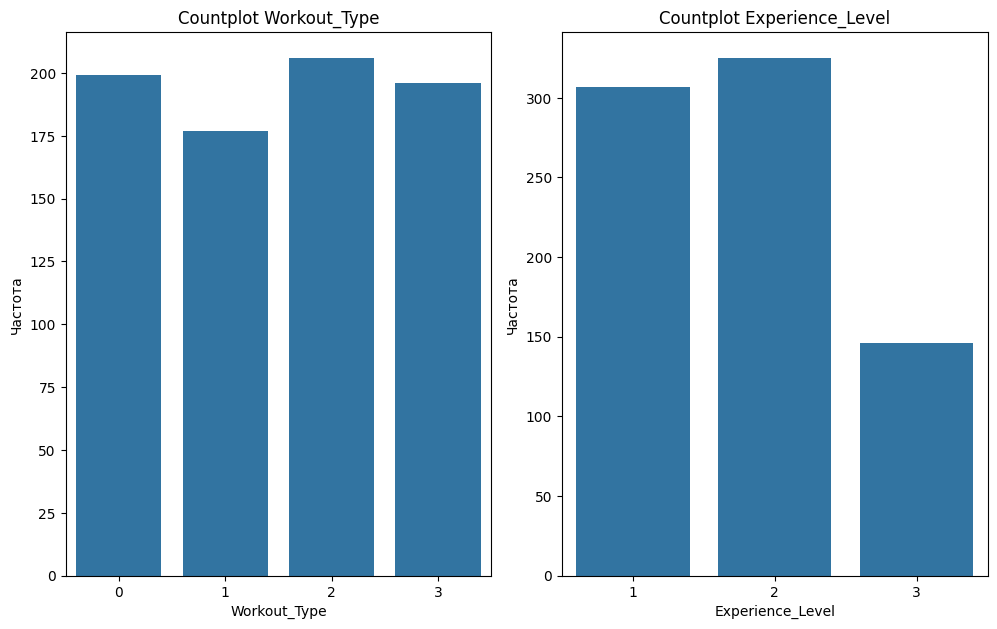

In [26]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 6))
axes = axes.flatten()

for idx, col in enumerate(categorical_columns):
    sns.countplot(x=train[col], ax=axes[idx])
    axes[idx].set_title(f'Countplot {col}')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Частота')

for i in range(len(categorical_columns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

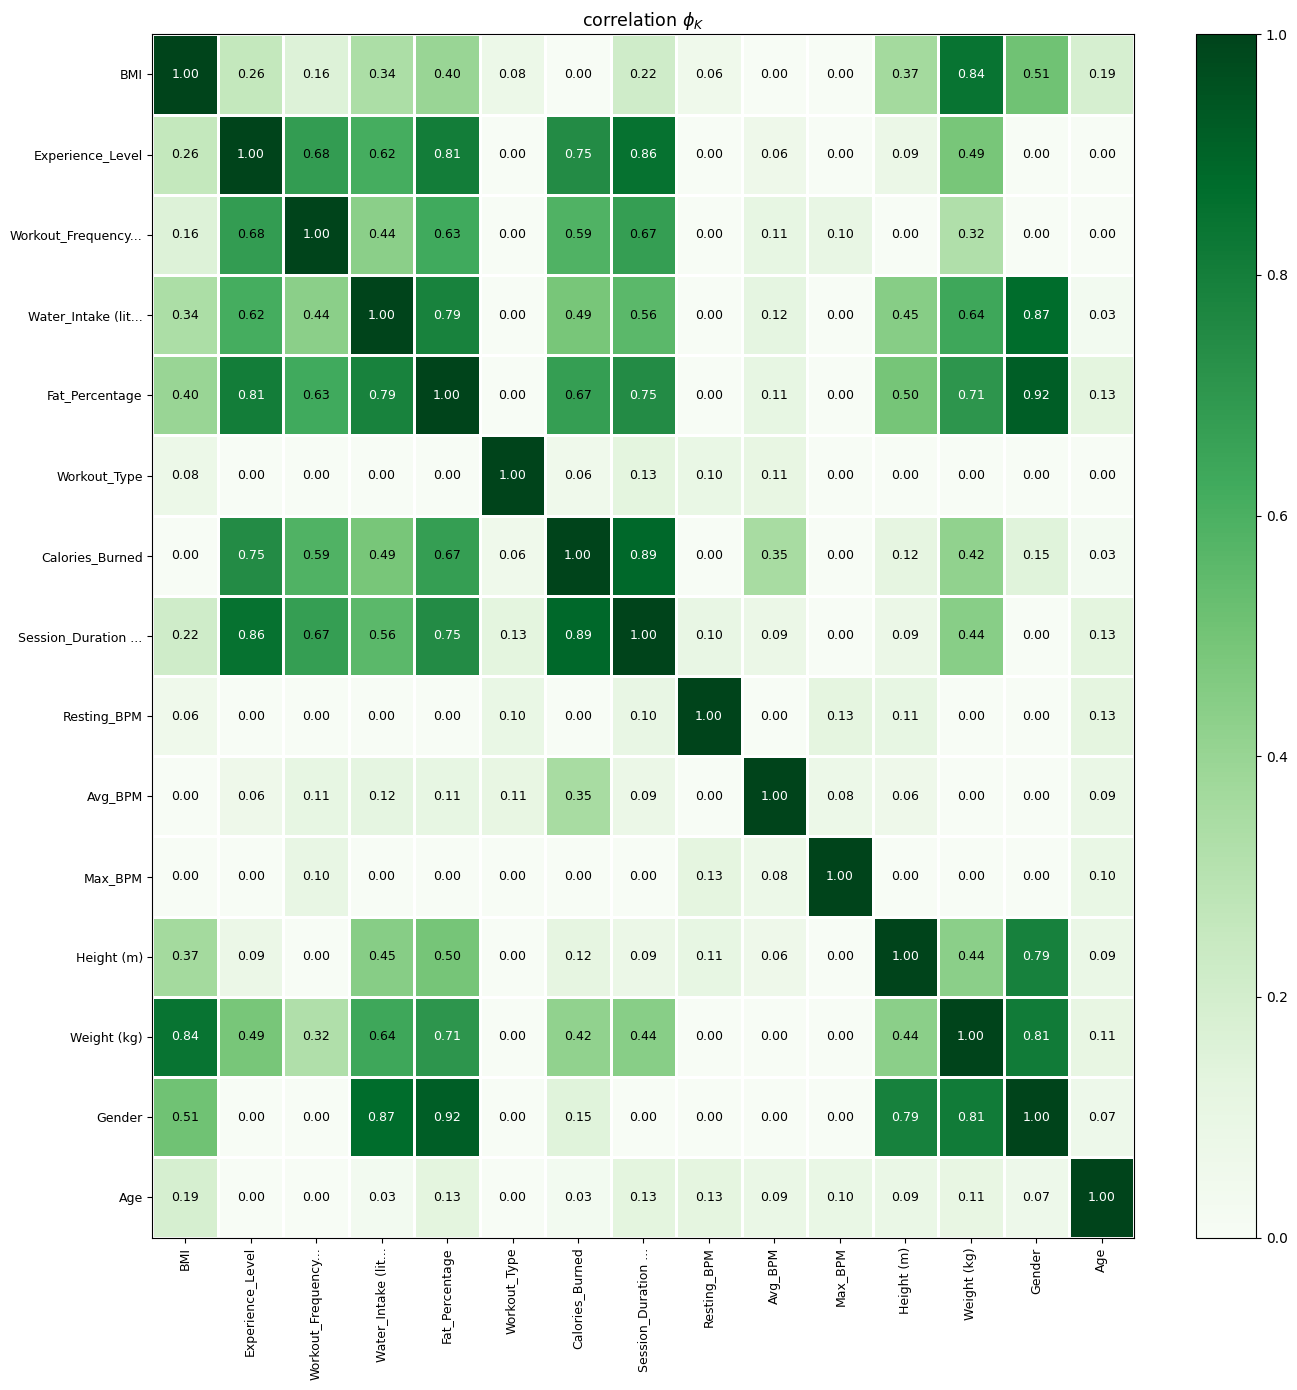

In [27]:
#3. Построение матрицы корреляции признаков
phik_overview = train.phik_matrix(interval_cols=numerical_columns)
plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="Greens",
                        title=r"correlation $\phi_K$",
                        fontsize_factor=0.9, figsize=(14, 14))
plt.tight_layout()

In [28]:
train.corr()

/tmp/ipykernel_42687/2189804198.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train.corr()


Age  Weight (kg)  Height (m)   Max_BPM  \
Age                            1.000000    -0.040006   -0.062051 -0.042879   
Weight (kg)                   -0.040006     1.000000    0.382534  0.075213   
Height (m)                    -0.062051     0.382534    1.000000  0.002295   
Max_BPM                       -0.042879     0.075213    0.002295  1.000000   
Avg_BPM                        0.027983     0.023862   -0.019495 -0.039139   
Resting_BPM                    0.004092    -0.047783   -0.024326  0.021997   
Session_Duration (hours)      -0.037546    -0.041212    0.022040 -0.005616   
Calories_Burned               -0.168679     0.076345    0.119081 -0.006585   
Fat_Percentage                 0.003756    -0.219903   -0.248291 -0.005669   
Water_Intake (liters)          0.044920     0.393560    0.404503  0.036889   
Workout_Frequency (days/week)  0.034825    -0.040537   -0.002818 -0.040036   
BMI                            0.001718     0.858901   -0.130848  0.075287   

                                Avg_BPM  Resting_BPM  \
Age                            0.027983     0.004092   
Weight (kg)                    0.023862    -0.047783   
Height (m)                    -0.019495    -0.024326   
Max_BPM                       -0.039139     0.021997   
Avg_BPM                        1.000000     0.065789   
Resting_BPM                    0.065789     1.000000   
Session_Duration (hours)       0.011420    -0.009349   
Calories_Burned                0.333653     0.022984   
Fat_Percentage                -0.013268    -0.014737   
Water_Intake (liters)          0.007765    -0.006619   
Workout_Frequency (days/week) -0.020372     0.001884   
BMI                            0.041170    -0.037344   

                               Session_Duration (hours)  Calories_Burned  \
Age                                           -0.037546        -0.168679   
Weight (kg)                                   -0.041212         0.076345   
Height (m)                                     0.022040         0.119081   
Max_BPM                                       -0.005616        -0.006585   
Avg_BPM                                        0.011420         0.333653   
Resting_BPM                                   -0.009349         0.022984   
Session_Duration (hours)                       1.000000         0.910293   
Calories_Burned                                0.910293         1.000000   
Fat_Percentage                                -0.568019        -0.586206   
Water_Intake (liters)                          0.259898         0.336945   
Workout_Frequency (days/week)                  0.641156         0.562574   
BMI                                           -0.053395         0.023237   

                               Fat_Percentage  Water_Intake (liters)  \
Age                                  0.003756               0.044920   
Weight (kg)                         -0.219903               0.393560   
Height (m)                          -0.248291               0.404503   
Max_BPM                             -0.005669               0.036889   
Avg_BPM                             -0.013268               0.007765   
Resting_BPM                         -0.014737              -0.006619   
Session_Duration (hours)            -0.568019               0.259898   
Calories_Burned                     -0.586206               0.336945   
Fat_Percentage                       1.000000              -0.571666   
Water_Intake (liters)               -0.571666               1.000000   
Workout_Frequency (days/week)       -0.509447               0.209069   
BMI                                 -0.110720               0.214023   

                               Workout_Frequency (days/week)       BMI  
Age                                                 0.034825  0.001718  
Weight (kg)                                        -0.040537  0.858901  
Height (m)                                         -0.002818 -0.130848  
Max_BPM                                            -0.040036  0.075287  
A

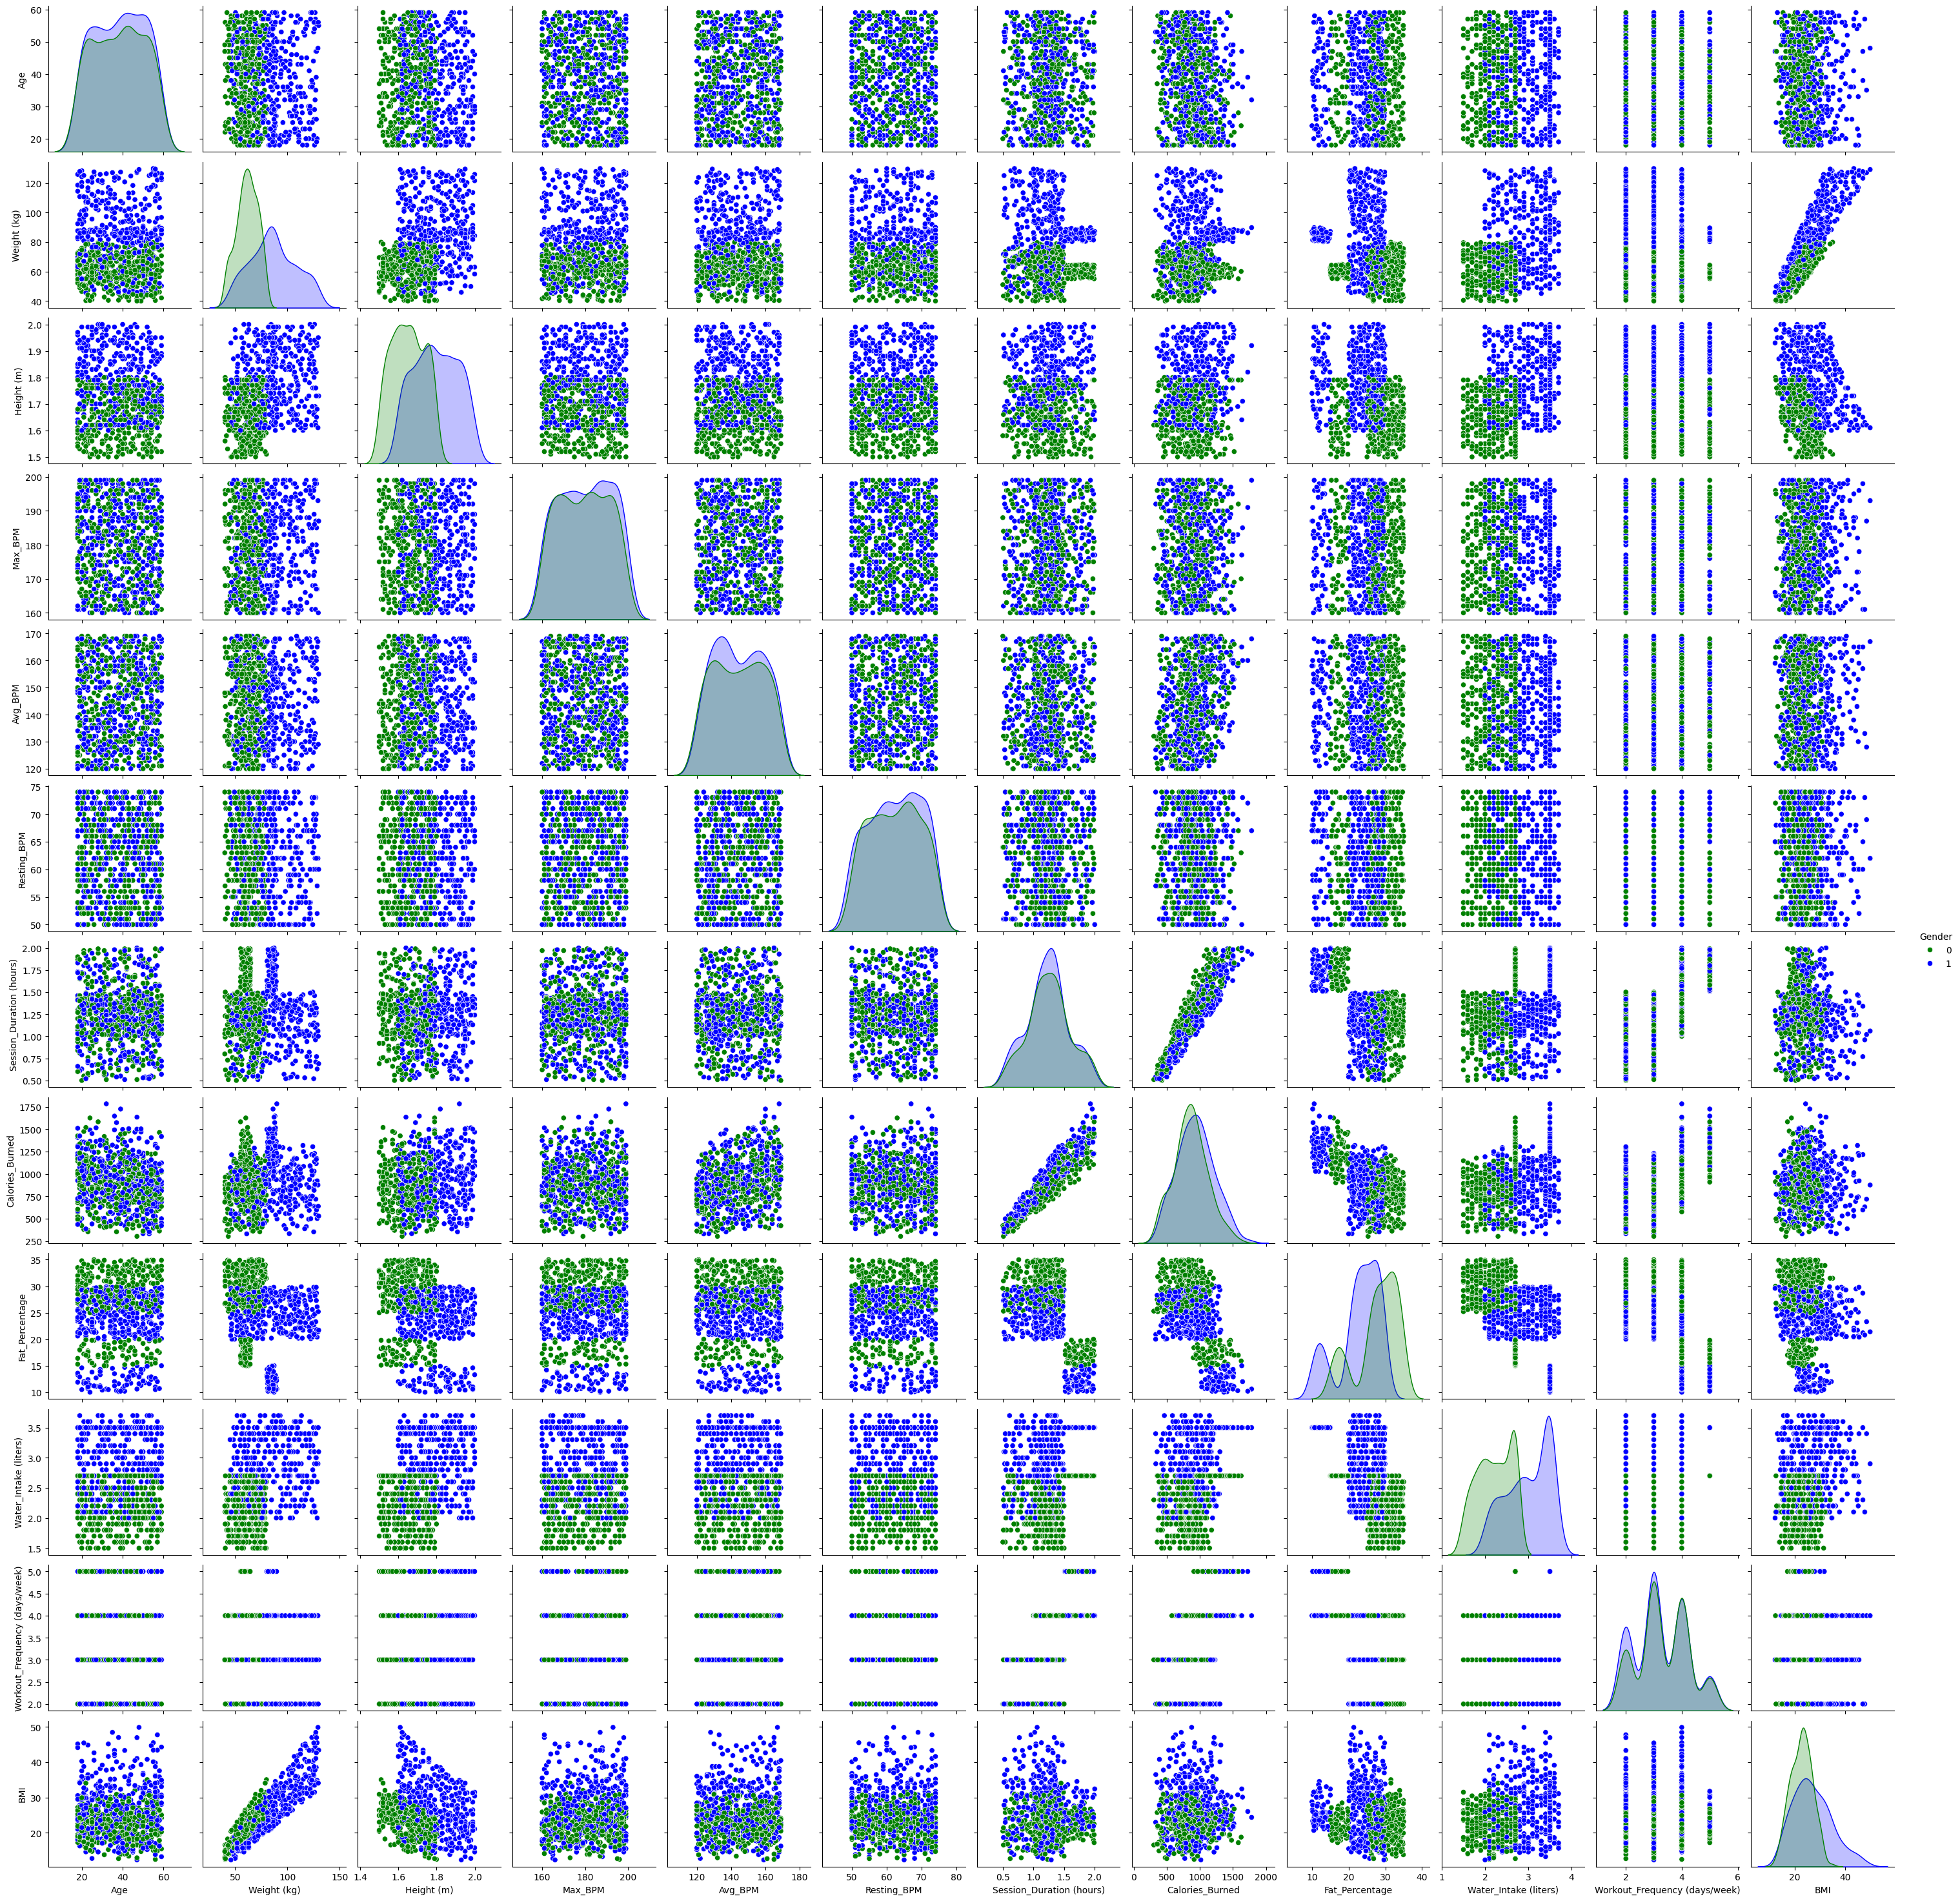

In [29]:
# 2. Построение pairplot
sns.pairplot(train, hue=target_columns, palette=['green', 'blue'])
plt.show()

### Вывод:
- Выбросы в BMI, весе и калориях играют важную роль, поэтому их не стоит удалять.
- Есть колонки, имеющие нулевую корреляцию с gender: их стоит удалить.
- Остальные колонки имеют высокую корреляцию, потому стоит оставить только их, те оставить только признаки, у которых корреляция больше 0.1.
- После удаления слабых признаков стоит подумать над корреляцией оставшихся фичей

### Удаление колонок, имеющих низкую корреляцию с таргетом

In [30]:
# Выбираем колонки с корреляцией с Gender > 0.1
filtered_columns = phik_overview.loc[phik_overview['Gender'] > 0.05, 'Gender'].index

# Формируем новый DataFrame с выбранными колонками
new_train = train[filtered_columns]

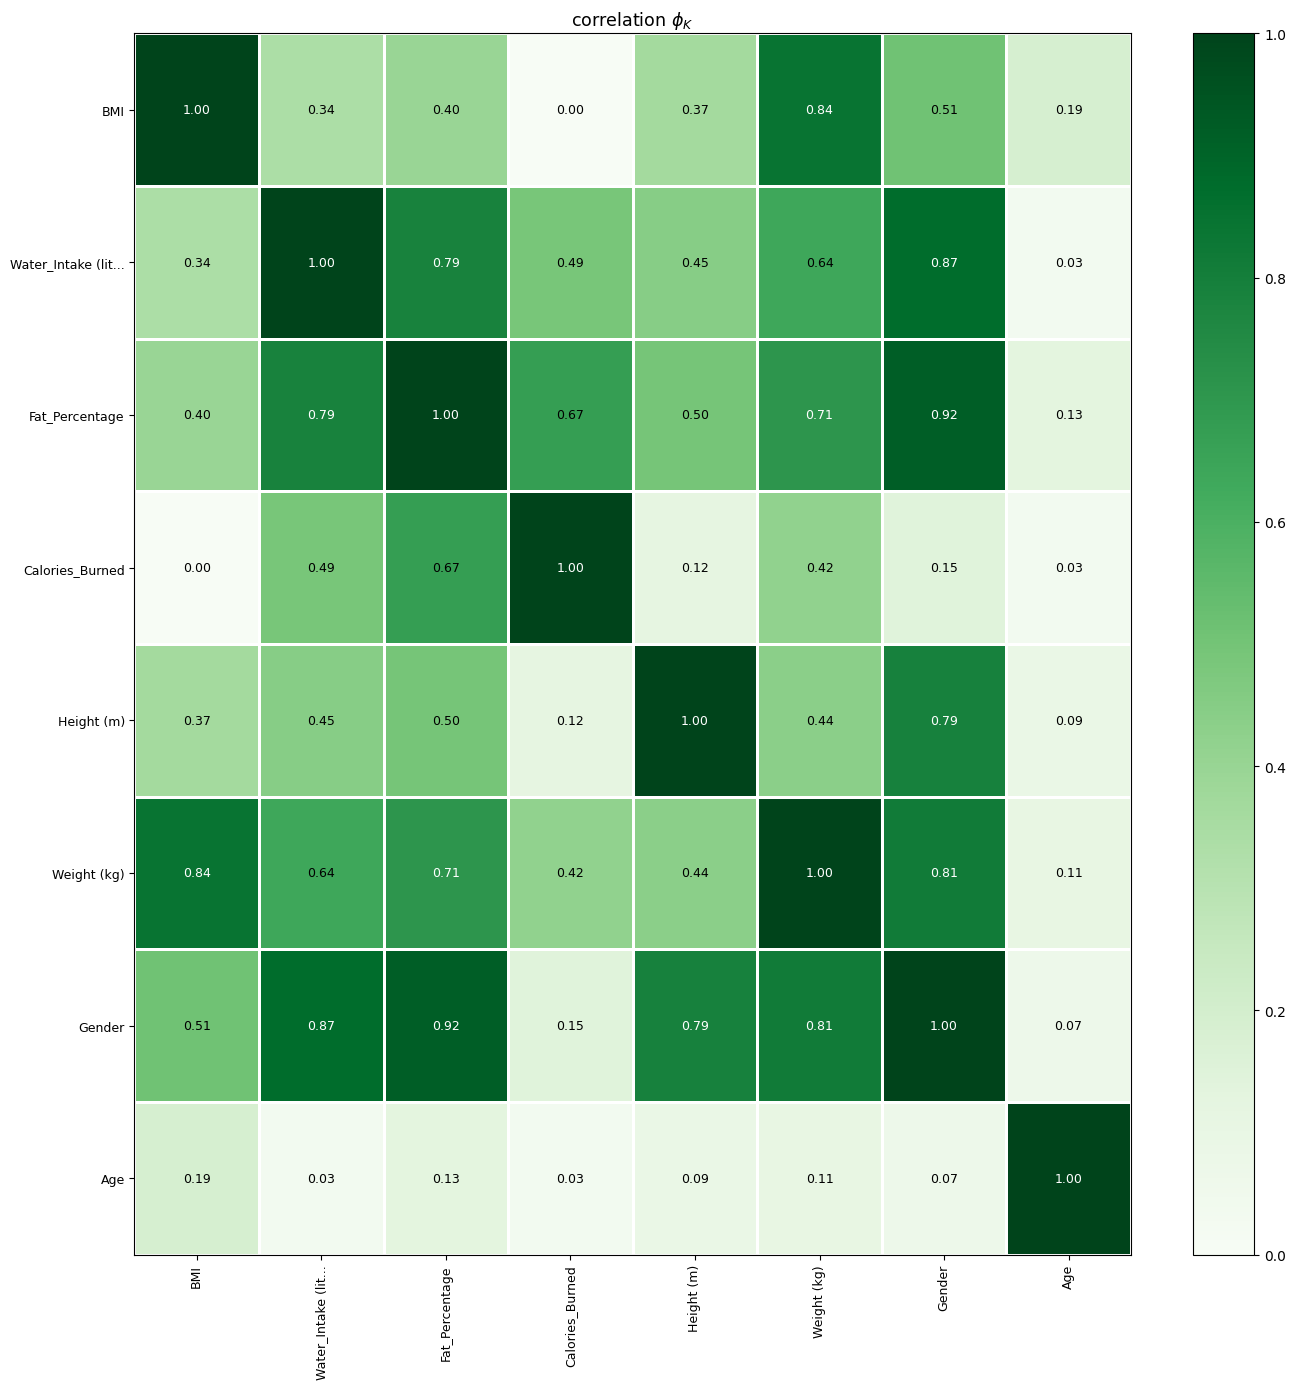

In [31]:
#3. Построение матрицы корреляции признаков
phik_overview = new_train.phik_matrix(interval_cols=numerical_columns)
plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="Greens",
                        title=r"correlation $\phi_K$",
                        fontsize_factor=0.9, figsize=(14, 14))
plt.tight_layout()

Как видим, высокая корреляция у признаков между собой, поэтому избавимся от нее

### Избавимся от корреляции

In [32]:
new_X_train = new_train.drop(columns=["Gender"], inplace=False)
new_y_train = new_train["Gender"]
new_valid = valid[filtered_columns]
new_X_valid = new_valid.drop(columns=["Gender"], inplace=False)
new_y_valid = new_valid["Gender"]

In [33]:
pca = PCA(n_components=len(filtered_columns)-1)
scaler = StandardScaler()
pca.fit(scaler.fit_transform(new_X_train))

PCA(n_components=7)

In [34]:
pca.explained_variance_ratio_

array([0.36380005, 0.22617939, 0.15163283, 0.14341653, 0.06766221,
       0.04644399, 0.000865  ])

Как видим, за 6 компоненты можно почти описать все данные, потому оставим 4 компоненты

### Обучаем на новых данных

Также добавим нормировку, чтобы выбросы сильно не влияли на результаты

In [35]:
model = Pipeline((
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=6)),
    ("model", KNeighborsClassifier())
))

In [36]:
model.fit(new_X_train, new_y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=6)),
                ('model', KNeighborsClassifier())])

Делаем предсказания по тренировочной выборке и валидационной

In [37]:
train_predict = model.predict(new_X_train)
valid_predict = model.predict(new_X_valid)

### B: Оценка качества модели

In [38]:
# Расчет метрик для тренировочных предсказаний
train_f1 = f1_score(y_train, train_predict)
train_balanced_accuracy = balanced_accuracy_score(y_train, train_predict)
train_precision = precision_score(y_train, train_predict, average='macro')
train_recall = recall_score(y_train, train_predict, average='macro')

# Расчет метрик для валидационных предсказаний
valid_f1 = f1_score(y_valid, valid_predict)
valid_balanced_accuracy = balanced_accuracy_score(y_valid, valid_predict)
valid_precision = precision_score(y_valid, valid_predict, average='macro')
valid_recall = recall_score(y_valid, valid_predict, average='macro')

# Сводка метрик в таблицу для удобного отображения
metrics_df = pd.DataFrame({
    'Метрика': ['F1', 'Balanced Accuracy', 'Precision', 'Recall'],
    'Тренировочная выборка': [train_f1, train_balanced_accuracy, train_precision, train_recall],
    'Валидационная выборка': [valid_f1, valid_balanced_accuracy, valid_precision, valid_recall]
})

In [39]:
metrics_df.head()

Метрика  Тренировочная выборка  Валидационная выборка
0                 F1               0.958491               0.965517
1  Balanced Accuracy               0.958995               0.964263
2          Precision               0.957809               0.963872
3             Recall               0.958995               0.964263

Визуализируем метрики

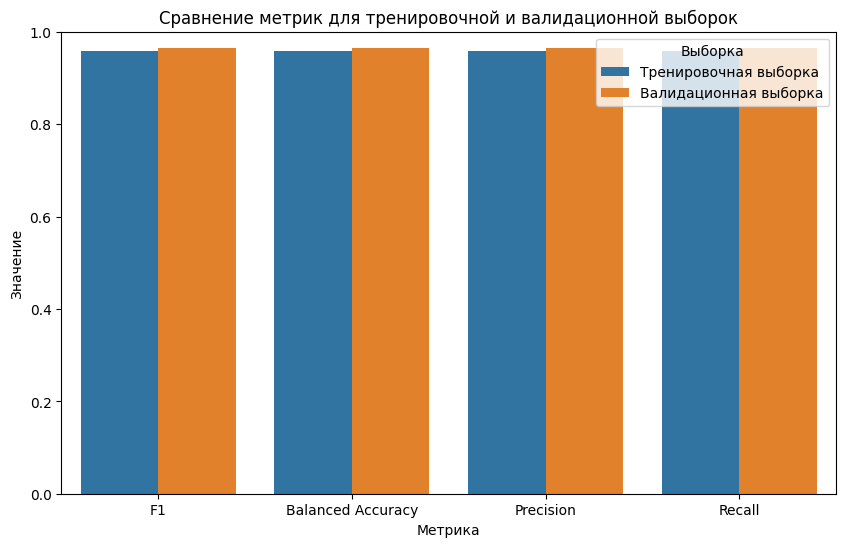

In [40]:
# Визуализация метрик
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df.melt(id_vars='Метрика', var_name='Выборка', value_name='Значение'),
            x='Метрика', y='Значение', hue='Выборка')
plt.title('Сравнение метрик для тренировочной и валидационной выборок')
plt.ylim(0, 1)
plt.legend(title='Выборка')
plt.show()

Отлично, результат сильно лучше!

## Импортируем собственную реализацию модели ближайших соседей

In [41]:
from implementation import MyKNeighborsClassifier

### Обучаем модель

In [42]:
model = MyKNeighborsClassifier()

In [43]:
model.fit(X_train, y_train)

Делаем предсказания по тренировочной выборке и валидационной

In [44]:
train_predict = model.predict(X_train)
valid_predict = model.predict(X_valid)

### B: Оценка качества модели

In [45]:
# Расчет метрик для тренировочных предсказаний
train_f1 = f1_score(y_train, train_predict)
train_balanced_accuracy = balanced_accuracy_score(y_train, train_predict)
train_precision = precision_score(y_train, train_predict, average='macro')
train_recall = recall_score(y_train, train_predict, average='macro')

# Расчет метрик для валидационных предсказаний
valid_f1 = f1_score(y_valid, valid_predict)
valid_balanced_accuracy = balanced_accuracy_score(y_valid, valid_predict)
valid_precision = precision_score(y_valid, valid_predict, average='macro')
valid_recall = recall_score(y_valid, valid_predict, average='macro')

# Сводка метрик в таблицу для удобного отображения
metrics_df = pd.DataFrame({
    'Метрика': ['F1', 'Balanced Accuracy', 'Precision', 'Recall'],
    'Тренировочная выборка': [train_f1, train_balanced_accuracy, train_precision, train_recall],
    'Валидационная выборка': [valid_f1, valid_balanced_accuracy, valid_precision, valid_recall]
})

In [46]:
metrics_df.head()

Метрика  Тренировочная выборка  Валидационная выборка
0                 F1               0.843061               0.764398
1  Balanced Accuracy               0.847175               0.771822
2          Precision               0.847933               0.773320
3             Recall               0.847175               0.771822

Визуализируем метрики

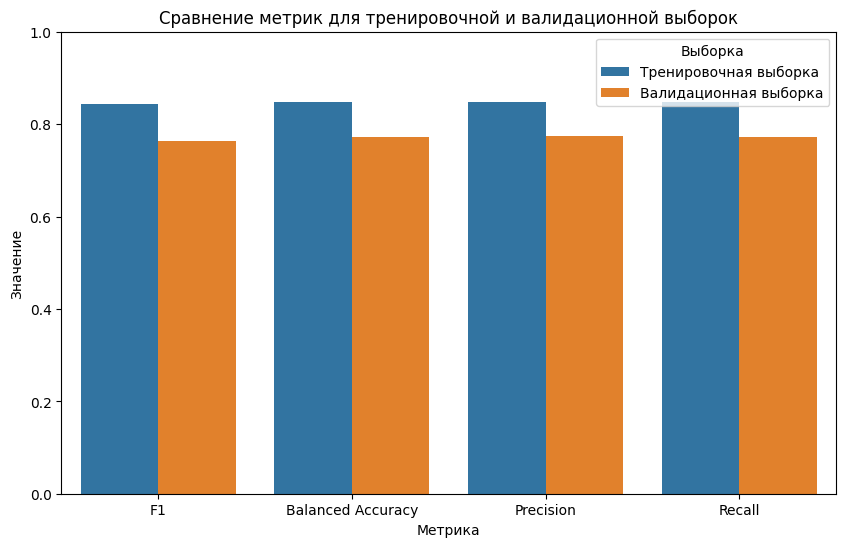

In [47]:
# Визуализация метрик
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df.melt(id_vars='Метрика', var_name='Выборка', value_name='Значение'),
            x='Метрика', y='Значение', hue='Выборка')
plt.title('Сравнение метрик для тренировочной и валидационной выборок')
plt.ylim(0, 1)
plt.legend(title='Выборка')
plt.show()

### Обучаем с улучшенным бейзлайном

In [48]:
model = Pipeline((
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=4)),
    ("model", MyKNeighborsClassifier())
))

In [49]:
model.fit(new_X_train, new_y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=4)),
                ('model',
                 <implementation.KNN.MyKNeighborsClassifier object at 0x7b220057db70>)])

Делаем предсказания по тренировочной выборке и валидационной

In [50]:
train_predict = model.predict(new_X_train)
valid_predict = model.predict(new_X_valid)

### B: Оценка качества модели

In [51]:
# Расчет метрик для тренировочных предсказаний
train_f1 = f1_score(y_train, train_predict)
train_balanced_accuracy = balanced_accuracy_score(y_train, train_predict)
train_precision = precision_score(y_train, train_predict, average='macro')
train_recall = recall_score(y_train, train_predict, average='macro')

# Расчет метрик для валидационных предсказаний
valid_f1 = f1_score(y_valid, valid_predict)
valid_balanced_accuracy = balanced_accuracy_score(y_valid, valid_predict)
valid_precision = precision_score(y_valid, valid_predict, average='macro')
valid_recall = recall_score(y_valid, valid_predict, average='macro')

# Сводка метрик в таблицу для удобного отображения
metrics_df = pd.DataFrame({
    'Метрика': ['F1', 'Balanced Accuracy', 'Precision', 'Recall'],
    'Тренировочная выборка': [train_f1, train_balanced_accuracy, train_precision, train_recall],
    'Валидационная выборка': [valid_f1, valid_balanced_accuracy, valid_precision, valid_recall]
})

In [52]:
metrics_df.head()

Метрика  Тренировочная выборка  Валидационная выборка
0                 F1               0.952381               0.941748
1  Balanced Accuracy               0.952353               0.937856
2          Precision               0.951157               0.938874
3             Recall               0.952353               0.937856

Визуализируем метрики

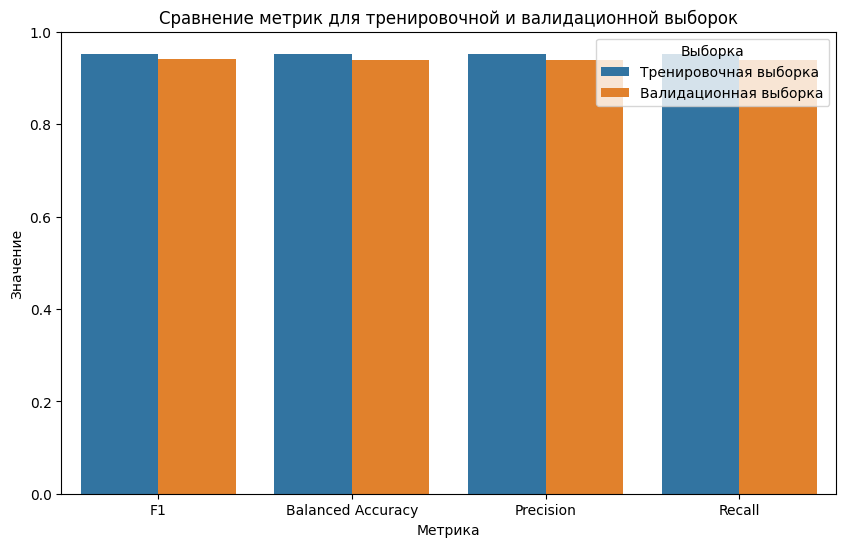

In [53]:
# Визуализация метрик
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df.melt(id_vars='Метрика', var_name='Выборка', value_name='Значение'),
            x='Метрика', y='Значение', hue='Выборка')
plt.title('Сравнение метрик для тренировочной и валидационной выборок')
plt.ylim(0, 1)
plt.legend(title='Выборка')
plt.show()

## Вывод:
Как видим, модель, написанная мною работает аналогично модели sklearn, что очень радует!